Notebook adapted from https://github.com/stevetjoa/musicinformationretrieval.com

In [0]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, sklearn, IPython.display as ipd
import librosa, librosa.display
import urllib
import warnings
warnings.simplefilter("ignore")

# Nonnegative Matrix Factorization

[Nonnegative matrix factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) (NMF) is an algorithm that factorizes a nonnegative matrix, $X$, into a product of two nonnegative matrices, $W$ and $H$. It is an unsupervised iterative algorithm that minimizes a distance between $X$ and the product $WH$:

$$ \min_{W, H} d(X, WH) $$

If $X$ has dimensions $M$ by $N$, then $W$ will have dimensions $M$ by $R$, and $H$ will have dimensions $R$ by $N$, where inner dimension $R$ is the *rank* or *number of components* of the decomposition.

When applied to a musical signal, we find that NMF can decompose the signal into separate note events. Therefore, NMF is quite useful and popular for tasks such as transcription and source separation.

The input, $X$, is often a magnitude spectrogram. In such a case, we find that the columns of $W$ represent spectra of note events, and the rows of $H$ represent temporal envelopes of the same note events.

Let's load a signal:

In [2]:
!pip install -q gdown httpimport

![ -e kotek.mp3 ] || gdown 'https://drive.google.com/uc?id=1DDERnPF7sBqfy7UBnWZMlrEOQsLizBGE' -O kotek.mp3

Downloading...
From: https://drive.google.com/uc?id=1DDERnPF7sBqfy7UBnWZMlrEOQsLizBGE
To: /content/kotek.mp3
100% 687k/687k [00:00<00:00, 91.3MB/s]


In [0]:
x, sr = librosa.load('kotek.mp3')

In [4]:
ipd.Audio(x, rate=sr)

Compute the STFT:

In [0]:
S = librosa.stft(x)

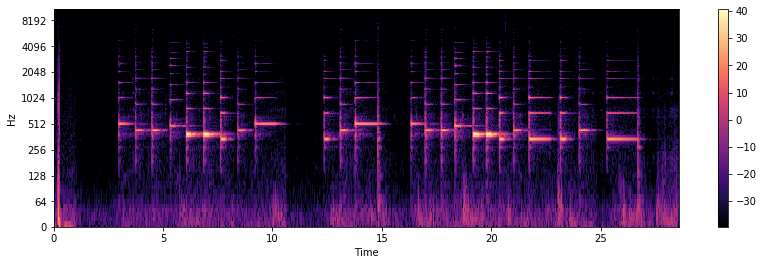

In [6]:
S_db = librosa.amplitude_to_db(abs(S))
plt.figure(figsize=(14, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

## `librosa.decompose.decompose`

We will use [`librosa.decompose.decompose`](https://librosa.github.io/librosa/generated/librosa.decompose.decompose.html#librosa.decompose.decompose) to perform our factorization. `librosa` uses [`sklearn.decomposition.NMF`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF) by default as its factorization method.

In [0]:
X, X_phase = librosa.magphase(S)
n_components = 5
W, H = librosa.decompose.decompose(X, n_components=n_components, sort=True)

In [8]:
print(W.shape)
print(H.shape)

(1025, 5)
(5, 1230)


Let's display the spectral profiles, $\{w_1, ..., w_R\}$:

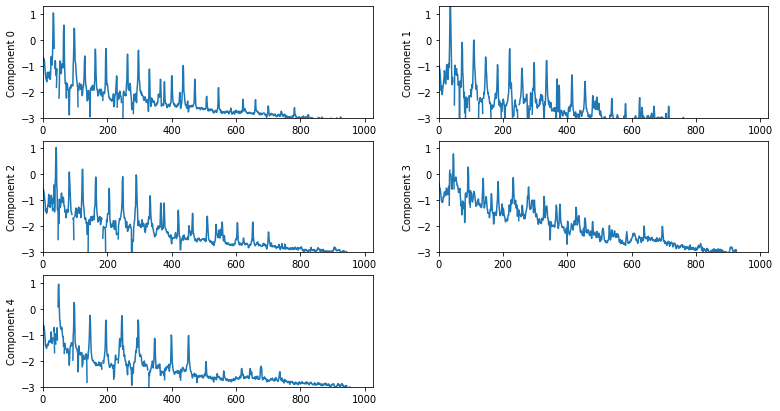

In [9]:
plt.figure(figsize=(13, 7))
logW = numpy.log10(W)
for n in range(n_components):
    plt.subplot(numpy.ceil(n_components/2.0), 2, n+1)
    plt.plot(logW[:,n])
    plt.ylim(-3, logW.max())
    plt.xlim(0, W.shape[0])
    plt.ylabel('Component %d' % n)

Let's display the temporal activations, $\{h_1, ..., h_R\}$:

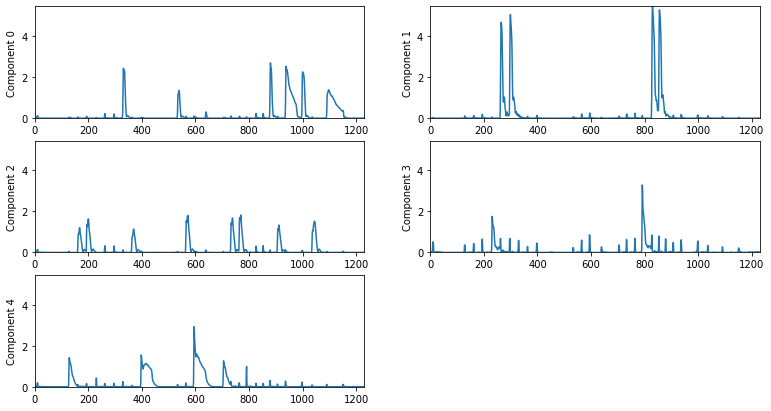

In [10]:
plt.figure(figsize=(13, 7))
for n in range(n_components):
    plt.subplot(numpy.ceil(n_components/2.0), 2, n+1)
    plt.plot(H[n])
    plt.ylim(0, H.max())
    plt.xlim(0, H.shape[1])
    plt.ylabel('Component %d' % n)

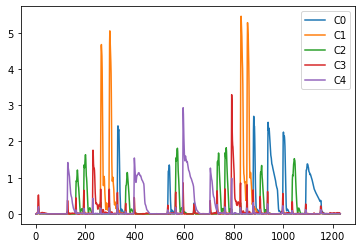

In [11]:
for i in range(H.shape[0]):
    plt.plot(H[i], label=f'C{i}')
plt.legend()

Compare with the notes:
![alt text](https://upload.wikimedia.org/wikipedia/commons/a/a1/Wlazlkotek_4_ubt.png)

Finally, re-create the individual components, and listen to them. To do this, we will reconstruct the magnitude spectrogram from the NMF outputs and use the phase spectrogram from the original signal.

In [12]:
for n in range(n_components):
    
    # Re-create the STFT of a single NMF component.
    Y = scipy.outer(W[:,n], H[n])*X_phase
    
    # Transform the STFT into the time domain.
    y = librosa.istft(Y)
    
    print('Component {}:'.format(n))
    ipd.display( ipd.Audio(y, rate=sr) )

Output hidden; open in https://colab.research.google.com to view.

Listen to the reconstructed full mix:

In [0]:
# Re-create the STFT from all NMF components.
Y = numpy.dot(W, H)*X_phase

# Transform the STFT into the time domain.
reconstructed_signal = librosa.istft(Y, length=len(x))
ipd.Audio(reconstructed_signal, rate=sr)

Listen to the residual:

In [0]:
residual = x - reconstructed_signal
residual[0] = 1 # hack to prevent automatic gain scaling
ipd.Audio(residual, rate=sr)

## For Further Exploration

Use different audio files.

Alter the rank of the decomposition, `n_components`. What happens when `n_components` is too large? too small?

NMF is a useful preprocessor for MIR tasks such as music transcription. Using the steps above, build your own simple transcription system that returns a sequence of note events, `[(onset time, class label, volume/gain)...]`.

[&larr; Back to Index](index.html)